In [1]:
# Importing common libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import math

from IPython import display

In [29]:
plt.rcParams["figure.figsize"] = (20, 6)

# JPMC Case study 1 - Options Pricing

## Question 1: Probability & Monte Carlo Simulation

### Consider a company “XYZ capital” currently trading at \\$100 (at time = t0) on the National Stock Exchange of Vol-land and it moves up by \\$1 or moves down by the same amount with equal probability at each minute.
### a) What will be the expected value of stock price after:
    i) 1 minute
    ii) 10 minutes
    iii) 1 hour
    iv) 1 month
### Are all the values same? Please explain on why they should or should not be same

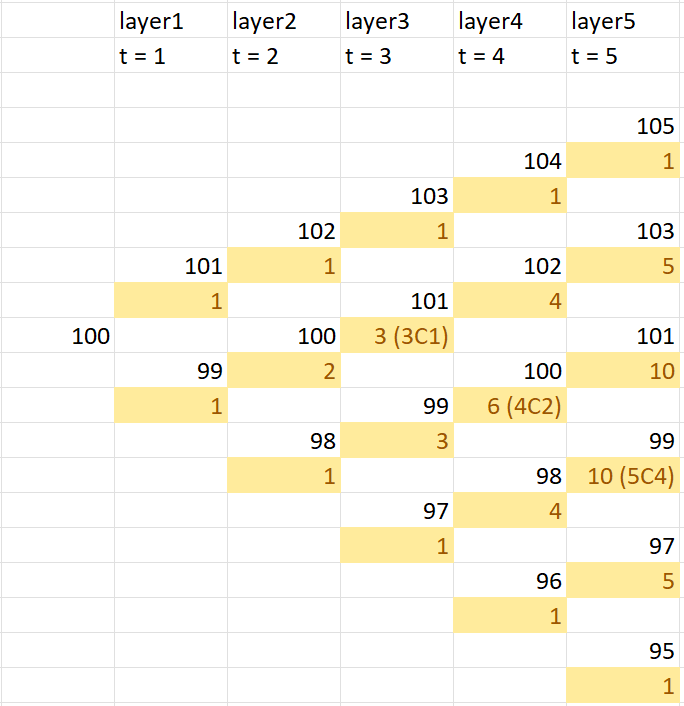

In [3]:
display.Image("C:\\Users\\jasme\\OneDrive\\Pictures\\Screenshots\\im2.png", width = 300)

#### In the above image I have described the terms I use in the comments for explaination
    Time = T => LayerT
    Index of the price I in layer T => Index of the price in the layer T
    The 'yellow' highlighted numbers represent the number of ways to reach a node/value/price an index I in layer T

In [4]:
# Since the number of ways to reach a point in the binomial lattice is nCr 
# Where n is the time that has passed and r is the index of the price for that time T.
import math
def nCr(n,r):
    return math.factorial(n) // math.factorial(r) // math.factorial(n-r)

In [5]:
# Combining the nCr ways to reach and multiplying with probability p to calculate probability of reaching a price P in time T
# Once we have probabilities at time T, we can use SUM(probability * price) to calculatre the expected value.

# I have defined an optional parameter diff, which can be used if the assumption about stock price changes (i.e. becomes more/less volatile) 
# and the stock is able to move up or down by a value which is greater or smaller than -1.
def getExpectedValueBinaryTree(minutes, diff = 1):
    lower = -diff * minutes
    layer = [[100 + lower, 0.5**minutes]]
    count = 1
    temp = lower
    while(temp < minutes):
        temp += 2 * diff
        layer.append([100 + temp, nCr(minutes, count) * (0.5 ** minutes)])
        count += 1

    expectedValue = 0
    if(len(layer) > 10):
        # Truncating the output of the layers for easy readability for the user
        print(layer[:2], '...', layer[-2:])
    else:
        print(layer)

    for i in layer:
        expectedValue += i[0] * i[1]
    
    return round(expectedValue, 4)

In [6]:
print(f'Expected Value after 1 minute = {getExpectedValueBinaryTree(1)}\n')
print(f'Expected Value after 10 minute = {getExpectedValueBinaryTree(10)}\n')
print(f'Expected Value after 60 minutes = {getExpectedValueBinaryTree(60)}')

[[99, 0.5], [101, 0.5]]
Expected Value after 1 minute = 100.0

[[90, 0.0009765625], [92, 0.009765625]] ... [[108, 0.009765625], [110, 0.0009765625]]
Expected Value after 10 minute = 100.0

[[40, 8.673617379884035e-19], [42, 5.204170427930421e-17]] ... [[158, 5.204170427930421e-17], [160, 8.673617379884035e-19]]
Expected Value after 60 minutes = 100.0


#### Since the possible values for stock will become less than 0 for time > 100 minutes, we need to calculate expected value for time t > 100 in a different manner
#### The price can't be negative and if the price becomes 0 in any path, it signals that the company is bankrupt and it can't go further. Therefore the above function 'getExpectedValueBinaryTree' can't be used for t > 100 minutes

In [7]:
# Defining a function that calculates the number ways to reach a price taking into consideration that the previous stock price is not zero
# Builds layer by layer starting from time = 1 to time = T in a top-down manner
def getExpectedValue(time, diff = 1, print_layer = True):
    layers = [[[100.0 + diff, 1.0, 0.5], [100.0 - diff, 1.0, 0.5]]]
    count = 0
    for i in range(1, time):
        lenght = len(layers[i - 1])
        last_layer = [x[0] for x in layers[i - 1]]
        last_layer_ways = [x[1] for x in layers[i - 1]]
        temp_layers = [[last_layer[0] + diff , 1.0, (0.5 ** (i + 1))]]
        count = 0
        for j in last_layer:
            curr_price = j - diff
            if(curr_price <= 0):
                temp_layers.append([0, 0])
            else:
                try:
                    temp_layers.append([curr_price, (last_layer_ways[count] + last_layer_ways[count + 1]),
                                   (0.5 ** (i + 1)) * (last_layer_ways[count] + last_layer_ways[count + 1])
                            ])
                except:
                    temp_layers.append([curr_price, last_layer_ways[count], (0.5 ** (i + 1)) * last_layer_ways[count]])
            count += 1
        layers.append(temp_layers)
    
    layer = layers[-1]
    expectedValue = 0.0
    if(print_layer == True):
        if(len(layer) > 10):
            print(layer[:3], '...', layer[-3:])
        else:
            print(layer)
    for i in layer:
        if(i[0] == 0):
            break
        expectedValue += (i[-1] * i[0])
        # raise Exception('rflj')
    return round(expectedValue, 4)

In [8]:
print(f'Expected Value after 1 minute = {getExpectedValue(1)}\n')
print(f'Expected Value after 10 minute = {getExpectedValue(10)}\n')
print(f'Expected Value after 60 minutes = {getExpectedValue(60)}\n')
print(f'Expected Value after 1 month (Assuming 1 trading day = 6hours and 20 trading days in a month) = {getExpectedValue(60 * 6 * 20)}\n')

[[101.0, 1.0, 0.5], [99.0, 1.0, 0.5]]
Expected Value after 1 minute = 100.0

[[110.0, 1.0, 0.0009765625], [108.0, 10.0, 0.009765625], [106.0, 45.0, 0.0439453125]] ... [[94.0, 45.0, 0.0439453125], [92.0, 10.0, 0.009765625], [90.0, 1.0, 0.0009765625]]
Expected Value after 10 minute = 100.0

[[160.0, 1.0, 8.673617379884035e-19], [158.0, 60.0, 5.204170427930421e-17], [156.0, 1770.0, 1.5352302762394743e-15]] ... [[44.0, 1770.0, 1.5352302762394743e-15], [42.0, 60.0, 5.204170427930421e-17], [40.0, 1.0, 8.673617379884035e-19]]
Expected Value after 60 minutes = 100.0

[[7300.0, 1.0, 0.0], [7298.0, 7200.0, 0.0], [7296.0, 25916400.0, 0.0]] ... [[0, 0], [0, 0], [0, 0]]
Expected Value after 1 month (Assuming 1 trading day = 6hours and 20 trading days in a month) = nan



In [9]:
## Due to system precision concerns, we can't directly used same methods for getting the expected value for one month, 
# Rather, we'll need to observe the pattern in expected values over time. 
# If the value remains constant for time t = t then we can conclude the value for t = 1 months

expectedValues = []
for i in tqdm(range(500)):
    expectedValues.append([i, getExpectedValue(i, diff = 1, print_layer = False)])
    
expectedValues_df = pd.DataFrame(expectedValues, columns = ['time', 'expectedValue']).set_index('time')
print(expectedValues_df.value_counts())

  0%|          | 0/500 [00:00<?, ?it/s]

expectedValue
100.0            500
dtype: int64


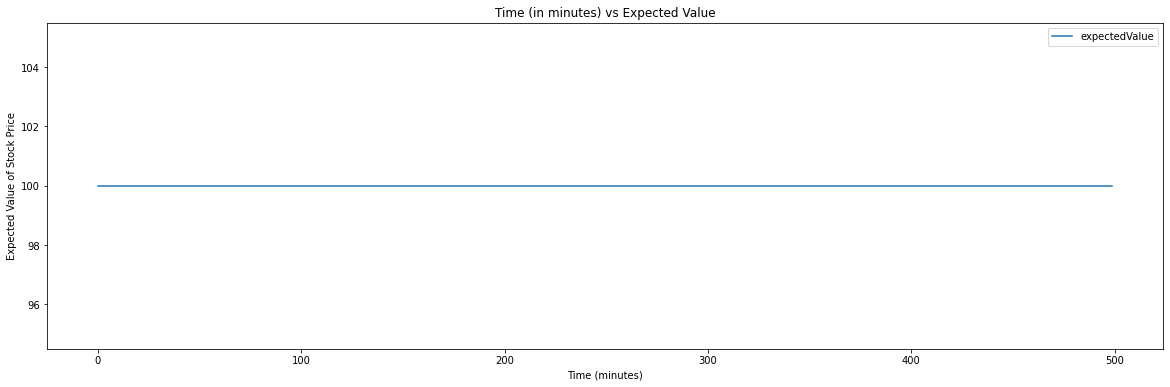

In [44]:
expectedValues_df.plot(title = 'Time (in minutes) vs Expected Value', xlabel = 'Time (minutes)', ylabel = 'Expected Value of Stock Price')
plt.show()

Here we can see that since the expected value is constant, we can conclude the the expected value for 1month will also be 100

### Ans1. (a):
#### The expected value for 1 minute, 10 minutes, 1 hour, 1 month will be same and the value will be $100

#### The reason being that since the binary tree is symmetric and the probabilty of an up and down move is same, we expect the values to remain constant.

#### Mathematically 
#### Expected value of up move = SUM(probab * (100 + 1)) 
#### Expected value of down move = SUM(probab * (100 - 1)) 
#### Therefore, the sum, i.e., the expected value = 100

#### For the cases when price on a path drops below zero, the expected value still remains the same at $100 is because, the number of ways to reach an index at time T is reduced which keeps the SUM(0.5 ^ time x expected ways x price) which keeps the expected value at 100. 

-----------------

### b) What will the probability of the stock price go to \\$102 before going to \\$96,
### i) Solve the probability analytically.
### ii) Find the probability using Monte Carlo method. In particular, how many paths will get you to the converged value? Plot the estimated Value vs Number of Paths
### NOTE: Tolerance limit between analytical and numerical solution is 10^-2 Solution

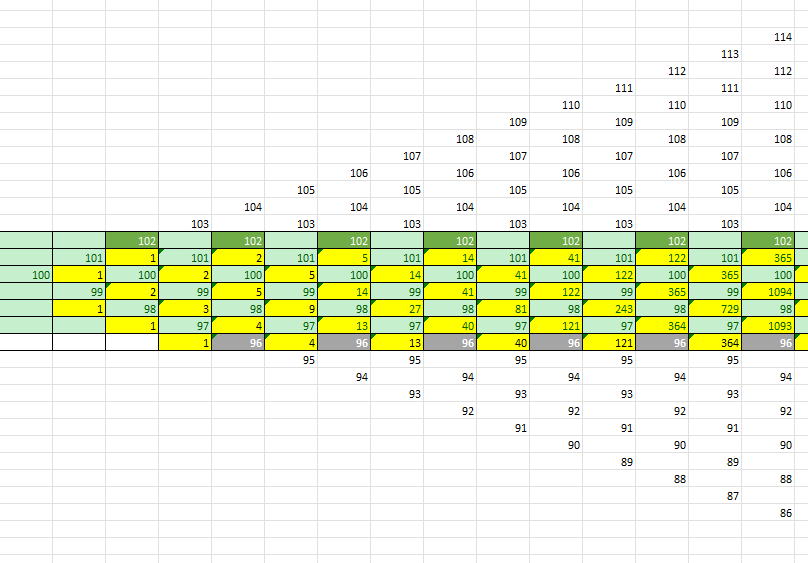

In [11]:
display.Image("C:\\Users\\jasme\\OneDrive\\Pictures\\Screenshots\\im1.png", width = 800)

#### Assumption about the problem:
#### The problem wants us to calculate the probability the stock price reached 102 without going to 96.
#### Ex:
    100-99-98-97-98-97-98-99-100-101-102 => favourable outcome
    100-99-98-99-100-99-98-97-96 => Unfavourable outcome
    
#### Therefore, we want to calculate the probability that the stock price remains in the highlighted range.
#### The yellow highlighted cells refer to the number of valid ways to reach a particular cell

#### Analytical Solution

In [12]:
## Similar to question 1(a), calculating the number of ways to reach the next layer in a top down manner
def getProbability(time_steps):
    series = [[1, 2, 1]]
    count = 0
    probability = (0.5 ** 2)
    for i in range(time_steps - 1):
        count += 1
        if(count % 2 != 0):
            series.append([series[count - 1][0], series[count - 1][0] +  series[count - 1][1], series[count - 1][1]])
        else:
            series.append([series[count - 1][0] + series[count - 1][1], series[count - 1][1] +  series[count - 1][2], series[count - 1][2]])
            # Since when time t is an even number the stock price is able to reach 102, we'll add it to the probability as a valid path
            probability += (series[count][2] * (0.5 ** (count + 2)))
    return round(probability, 4)

In [13]:
time_step = 100
print(f"The probability that the stock goes to 102 before going to 96 during the period of {time_step} timesteps is {getProbability(time_step)}")

The probability that the stock goes to 102 before going to 96 during the period of 100 timesteps is 0.6667


<AxesSubplot:title={'center':'Probability over time'}, xlabel='Time', ylabel='Probability'>

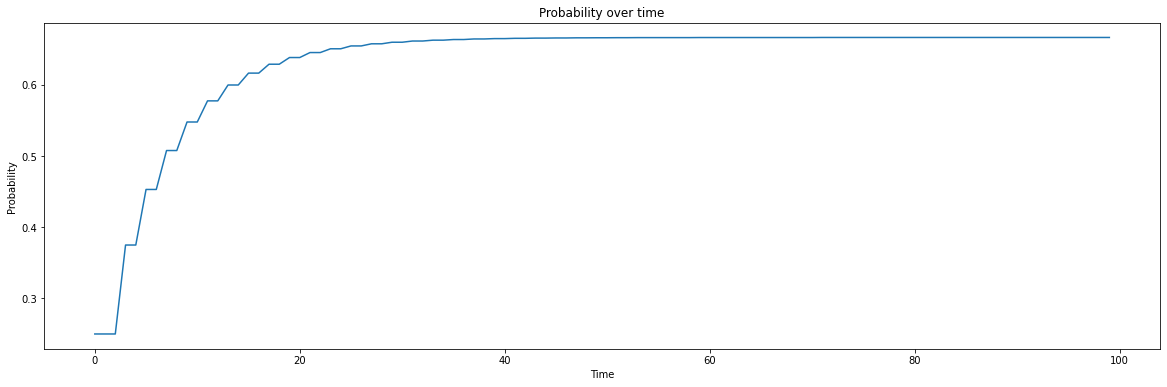

In [45]:
res = []
for i in range(100):
    res.append(getProbability(i))
    
pd.DataFrame(res).plot(legend = False, title = 'Probability over time', ylabel = 'Probability', xlabel = 'Time')

#### Here we can see that probability converges to 0.6667 after t ~ 40

#### MonteCarlo

In [15]:
import random

# Creating a function that randomly returns the next price difference (-1 or +1)
def getMovement():
    random_number = random.uniform(0, 1)
    while(random_number == 0.5):
        random_number = random.uniform(0, 1)
    if(random_number > 0.5):
        return 1
    if(random_number < 0.5):
        return -1

In [16]:
# Simulating paths
path = []
favour = 0
unfavour = 0
for paths in tqdm(range(10000)):
    P0 = 100
    res = [100]
    for i in range(100):
        P0 += getMovement()
        res.append(P0)
        # if the stock price hits 102 before 96, that's defined as a favourable outcome
        if(P0 == 102):
            favour += 1
            break
        # if the stock price hits 96 before 102, that's defined as an unfavourable outcome
        elif(P0 == 96):
            unfavour += 1
            break
    path.append(res)
    
print(favour / (favour + unfavour))

  0%|          | 0/10000 [00:00<?, ?it/s]

0.6716


#### Here we can see that the MC and Analytical methods are giving us the same probability of ~0.667

<AxesSubplot:title={'center':'Stock price paths vs time (100 paths)'}, xlabel='Time', ylabel='Price'>

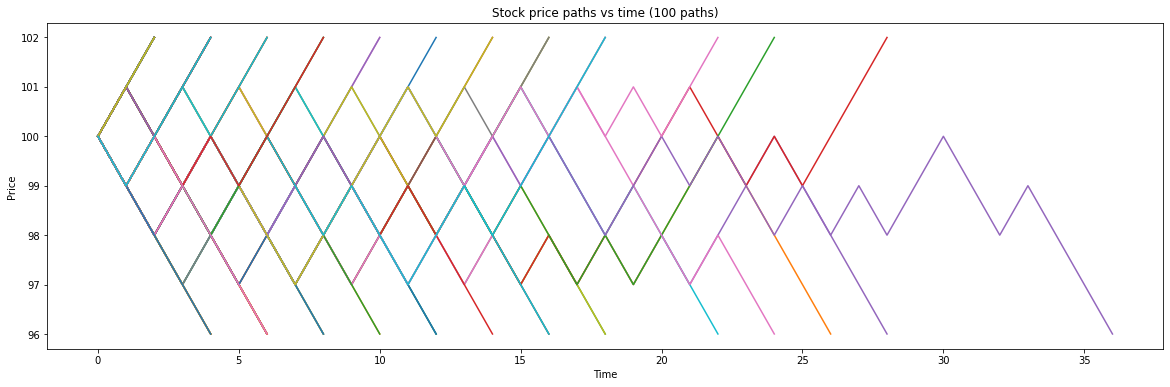

In [46]:
# Taking a sample of 100 paths to see price movement over time
pd.DataFrame(path).sample(100).T.plot(legend = False, title = 'Stock price paths vs time (100 paths)', ylabel = 'Price', xlabel = 'Time')

## Question 2: Pricing a Call Option analytically using Black Scholes formula

### Consider a company “XYZ capital” currently trading at \\$200 (at time = t0) on the National Stock Exchange of Vol-land. We have a call option contract with the following parameters:
    1. Strike: \$180
    2. Time To expiration: 30 days (1/12th of a year)
    3. Implied Vol: 15%
    4. Interest Rate: 2%
    5. Current Stock Price: $200
### Compute the value of the above-described option contract using Black Scholes formula. Please write a generic function to calculate Black-Scholes price and call the function with the inputs above.
### Suggested Solution Format: Please attach your code with comments, describe your steps to solve the problem as well.
### Note that you can rely on stats tools & packages for this exercise but are not allowed to directly import the black Scholes library if available on the open-source platform.

#### To calculate the value of an options price using BSM function. I used the close form equation for option price calculation. 
#### Price of long call = N(d1) * S - K * e^(-rT) * N(d2)

In [18]:
from scipy.stats import norm

In [19]:
# Initializing variables
K = 180
t = 30
sigma = 0.15
r = 0.02
S = 200
trading_days_in_year = 252
T = t / trading_days_in_year

In [20]:
def get_long_option_price(S, K, T, r, sigma, option_type='C'):
    
    # Making the function dynamic to handle put/call options
    # Using the factor of -1 for puts which is passed to BSM
    # Since the formulas of puts/calls are 'symmetric' 
    # We can re-use code for calls for puts as well
    if (option_type.upper() == 'CALL'):
        factor = 1
    elif (option_type.upper() == 'PUT'):
        factor = -1
    else:
        print("Invalid option type")
        return np.nan
    
    try:
        # The code calculates the values of d1 and d2, 
        # which are intermediate variables used in the closed-form Black-Scholes formula.
        d1 = factor * ((math.log(S/K) + (r + sigma**2 / 2)
                       * T) / (sigma * math.sqrt(T)))
        d2 = factor * (factor * d1 - sigma * math.sqrt(T))
        option_price = factor*(S * norm.cdf(d1) - K *
                               math.exp(-r * T) * norm.cdf(d2))
    except Exception as e:
        print(e)
        # In case of errors, return np.nan which can be used for exception handling in a down-stream application.
        return np.nan

    # The function returns the maximum value between option_price and 0. 
    # This ensures that the option price is never negative, as the price of an option cannot be negative.
    return max(option_price, 0) 

In [21]:
option_type='call'
BS_option_price = get_long_option_price(S, K, T, r, sigma, option_type)
print(f'The option price for a {option_type} option is ${round(BS_option_price, 6)}')

The option price for a call option is $20.494754


## Question 3: Pricing a Call Option using Monte Carlo Simulation

### As we discussed above the price of an option should be the present value of expected payoff of the option. Now consider a case where we know how the underlying asset moves with time and we also know how to compute the payoff of an option.
### The classic Black-Scholes-Merton model assumes that stock prices follow a lognormal distribution based on the principle that asset prices cannot take a negative value and are bounded by zero. This can be represented in the following stochastic differential equation: 
### 𝑑𝑆𝑡=𝑟𝑆𝑡𝑑𝑡+𝜎𝑆𝑡𝑑𝑍𝑡
### Where 𝑍𝑡 is a Brownian motion, which follows a standard normal distribution 𝑍𝑡~ 𝑁(0,1),
### Using the Euler Discretization Scheme to solve the equation above, we obtain the expression below that describes the underlying stock movement over time: 
### 𝑆𝑡=𝑆𝑡−1𝑒(𝑟− 0.5𝜎2)Δ𝑡+(𝜎√Δ𝑡) 𝑍𝑡
#### a) Please write a function to compute the price of a call option with the same parameters in Question 3, but using Monte Carlo simulation techniques.
#### b) Plot the price of the option vs number of paths.
### NOTE: You will have to define another variable time step (T- (T-1)) to discretize the process and simulate your paths. Each path will consist of list of stock prices, and please take 240 data points (time steps) for a single path.
### Suggested Solution Format: Please attach your code with comments, describe your steps to solve the problem as well.

In [22]:
# Assuming deltaT = 1
# Using np.random.randn to generate the random numbers
# The function will return the next price
def getNextStockprice(St_1, r, sigma, deltaT = 1):
    St = St_1 * np.exp(
                    (r - 0.5 * (sigma ** 2)) * deltaT + 
                    (sigma * (deltaT ** 0.5)) * np.random.randn(1)[0]
                )
    return St

In [23]:
St_1 = S

#### Exprimenting with 1000 runs

In [24]:
RUNS = 1000
DAYS = 240

paths = []
final_prices = []
for j in tqdm(range(RUNS)):
    calls = []
    last_price = St_1
    res = [St_1]
    for i in range(DAYS):
        # Since the r and sigma are annual values, we need to convert them to daily values (assuming trading days per year = 252)
        new_price = getNextStockprice(last_price, r / 252, sigma / (252 ** 0.5))
        last_price = new_price
        call_price = np.maximum(last_price - K, 0) / np.exp(r * i/252)
        res.append(last_price)
        calls.append(call_price)

    final_prices.append(np.mean(calls))
    paths.append(res)

print(np.mean(final_prices))

  0%|          | 0/1000 [00:00<?, ?it/s]

22.843191066060033


<AxesSubplot:title={'center':'Monte Carlo paths for t = 240'}, xlabel='Time', ylabel='Stock Price'>

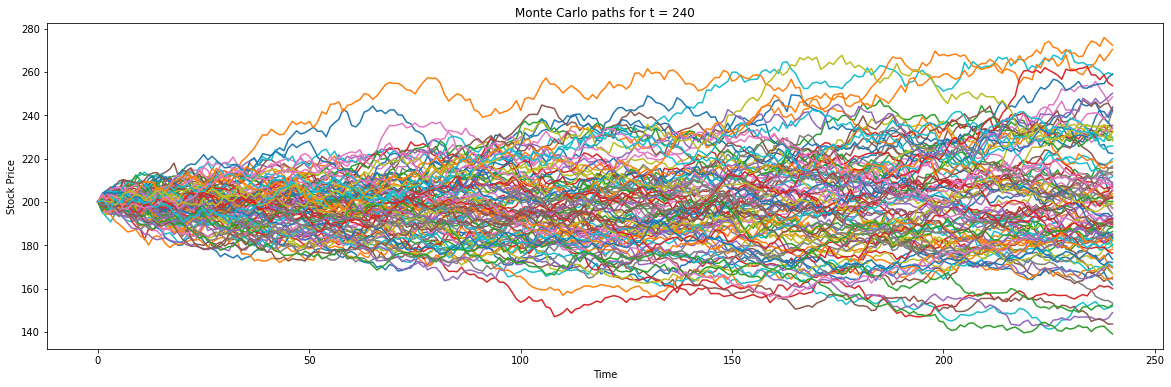

In [47]:
pd.DataFrame(paths).sample(100).T.plot(legend = False, title = 'Monte Carlo paths for t = 240', xlabel = 'Time', ylabel = 'Stock Price')

#### Experimenting with different number of runs

In [37]:
# Running if for numberOfRuns = RUNS
MC_runs = [50, 100, 500, 1000, 3000, 5000, 7000, 10000]
MC_prices = []
for RUNS in MC_runs:
    paths = []
    final_prices = []
    for j in tqdm(range(RUNS)):
        calls = []
        last_price = St_1
        res = [St_1]
        for i in range(DAYS):
            # Since the r and sigma are annual values, we need to convert them to daily values (assuming trading days per year = 252)
            new_price = getNextStockprice(last_price, r / 252, sigma / (252 ** 0.5))
            last_price = new_price
            call_price = np.maximum(last_price - K, 0) / np.exp(r * i/252)
            res.append(last_price)
            calls.append(call_price)

        final_prices.append(np.mean(calls))
        paths.append(res)
    
    MC_prices.append([RUNS, np.mean(final_prices)])

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

#### Plotting price of option vs paths and comparing it with Black Scholes prices

<AxesSubplot:title={'center':'Runs Vs MC Price'}, xlabel='Runs', ylabel='Price'>

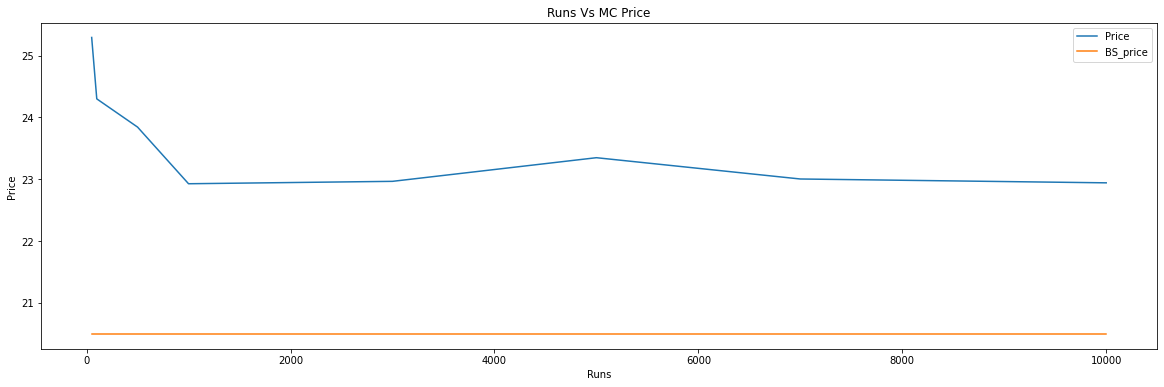

In [48]:
result = pd.DataFrame(MC_prices, columns = ['Runs', 'Price'])
result['BS_price'] = BS_option_price
result = result.set_index('Runs')
result.plot(title = 'Runs Vs MC Price', ylabel = 'Price', xlabel = 'Runs')